# Drive Mount

In [1]:

from google.colab import drive
drive.mount('/content/drive')

dataset = "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip"


Mounted at /content/drive


## Extract dataset

In [2]:
%%capture
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip" -d /content/

# Preprocessing

## Folder Paths

In [3]:
import os
#directory = "Desktop/Thesis/datasets/deepfake_database/deepfake_database/deepfake_database/train_test"
directory = os.path.join('deepfake_database', 'train_test')
image_format = '.jpg'

## Data Params

In [4]:
BATCH_SIZE = 64
SIZE = 256

## Store into tf.data.Dataset

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

training_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
)

validation_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)


Found 12353 files belonging to 2 classes.
Using 9883 files for training.
Found 12353 files belonging to 2 classes.
Using 2470 files for validation.


In [ ]:
import tensorflow as tf

def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.3)
    image = tf.image.random_flip_left_right(image)
    tf.image.random_hue(image, max_delta=0.3)
    tf.image.random_jpeg_quality(image, min_jpeg_quality=70, max_jpeg_quality=100)
    return image, label

training_dataset = training_dataset.map(augment)

## Store into DataGenerator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''
trainingGenerator = ImageDataGenerator(
    rotation_range=10,
    brightness_range= [0.5, 1.5],
    shear_range=0.2,
    zoom_range=[1.0, 1.3],
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    fill_mode="constant",
    cval=0.0,
    data_format="channels_last",
    validation_split=0.2,
)

validationGenerator = ImageDataGenerator(
    rescale=1./255,
    data_format="channels_last",
    validation_split=0.3,
)

training_dataset = trainingGenerator.flow_from_directory(
    directory,
    target_size=(SIZE, SIZE),
    color_mode="rgb",
    classes=['df', 'real'],
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    subset="training",
    interpolation="nearest",
)

validation_dataset = validationGenerator.flow_from_directory(
    directory,
    target_size=(SIZE, SIZE),
    color_mode="rgb",
    classes=['df', 'real'],
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    subset="validation",
    interpolation="nearest",
)

validation_gen = dataGenerator.flow(
    validation_dataset,
    target_size=(256, 256),
    color_mode="rgb",
    classes=['df', 'real'],
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    subset="validation",
)
'''

'\ntrainingGenerator = ImageDataGenerator(\n    rotation_range=10,\n    brightness_range= [0.5, 1.5],\n    shear_range=0.2,\n    zoom_range=[1.0, 1.3],\n    channel_shift_range=0.2,\n    horizontal_flip=True,\n    vertical_flip=False,\n    rescale=1./255,\n    fill_mode="constant",\n    cval=0.0,\n    data_format="channels_last",\n    validation_split=0.2,\n)\n\nvalidationGenerator = ImageDataGenerator(\n    rescale=1./255,\n    data_format="channels_last",\n    validation_split=0.3,\n)\n\ntraining_dataset = trainingGenerator.flow_from_directory(\n    directory,\n    target_size=(SIZE, SIZE),\n    color_mode="rgb",\n    classes=[\'df\', \'real\'],\n    class_mode="binary",\n    batch_size=BATCH_SIZE,\n    shuffle=True,\n    seed=123,\n    subset="training",\n    interpolation="nearest",\n)\n\nvalidation_dataset = validationGenerator.flow_from_directory(\n    directory,\n    target_size=(SIZE, SIZE),\n    color_mode="rgb",\n    classes=[\'df\', \'real\'],\n    class_mode="binary",\n    

# Model

## Model Params

In [7]:
input_shape = (SIZE, SIZE, 3)
learning_rate = 0.001
dl_rate = 1
EPOCHS = 50
ITERATIONS = len(training_dataset) * EPOCHS
print(ITERATIONS)

7750


## LR Decay

In [8]:
'''
import tensorflow as tf
from keras.optimizers.schedules import PiecewiseConstantDecay
step = tf.Variable(0, trainable=False)
boundaries = [1000, 1000, 1000]
values = [0.001, 0.0001, 0.00001, 0.000001]
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)

'''

'\nimport tensorflow as tf\nfrom keras.optimizers.schedules import PiecewiseConstantDecay\nstep = tf.Variable(0, trainable=False)\nboundaries = [1000, 1000, 1000]\nvalues = [0.001, 0.0001, 0.00001, 0.000001]\nlearning_rate_fn = PiecewiseConstantDecay(boundaries, values)\n\n# Later, whenever we perform an optimization step, we pass in the step.\nlearning_rate = learning_rate_fn(step)\n\n'

In [9]:
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    print("{0:.8f}".format(lr))
    if epoch < 20:
        return 0.001 # lr = 0.001
    elif epoch >= 20 and epoch < 30:
        return 0.001 # lr = 0.00001
    elif epoch >= 30 and epoch < 40:
        return 0.0001 # lr = 0.00001
    elif epoch >= 40:
        return 0.0001 # lr = 0.000001

## Custom Callback

## Compile Model

In [11]:
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras.optimizers import Adam

%run -i 'classifiers.py'

model, modelName = Meso4(input_shape)
optimizer = Adam(lr = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
# round(model.optimizer.lr.numpy(), 5)
# model.summary()
print(modelName)

Meso4


# Training

## Fit Model

In [14]:
from tensorflow import keras
import keras.backend as K

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    training_dataset, 
    epochs=EPOCHS, 
    validation_data=validation_dataset, 
    verbose = 1, 
    callbacks=[callback], 
    workers=4,
    use_multiprocessing=True,)

round(model.optimizer.lr.numpy(), 5)


Epoch 1/50
0.00100000
155/155 [==============================] - 28s 176ms/step - loss: 0.1601 - accuracy: 0.7749 - val_loss: 0.1087 - val_accuracy: 0.8567
Epoch 2/50
0.00100000
155/155 [==============================] - 27s 173ms/step - loss: 0.1139 - accuracy: 0.8430 - val_loss: 0.0736 - val_accuracy: 0.9053
Epoch 3/50
0.00100000
155/155 [==============================] - 27s 172ms/step - loss: 0.0947 - accuracy: 0.8738 - val_loss: 0.0730 - val_accuracy: 0.8984
Epoch 4/50
0.00100000
155/155 [==============================] - 27s 173ms/step - loss: 0.0821 - accuracy: 0.8919 - val_loss: 0.0712 - val_accuracy: 0.8960
Epoch 5/50
0.00100000
155/155 [==============================] - 28s 175ms/step - loss: 0.0740 - accuracy: 0.9006 - val_loss: 0.1402 - val_accuracy: 0.8053
Epoch 6/50
0.00100000
155/155 [==============================] - 27s 172ms/step - loss: 0.0694 - accuracy: 0.9072 - val_loss: 0.0523 - val_accuracy: 0.9308
Epoch 7/50
0.00100000
155/155 [==============================] -

1e-04

## Training and Validation Graphs

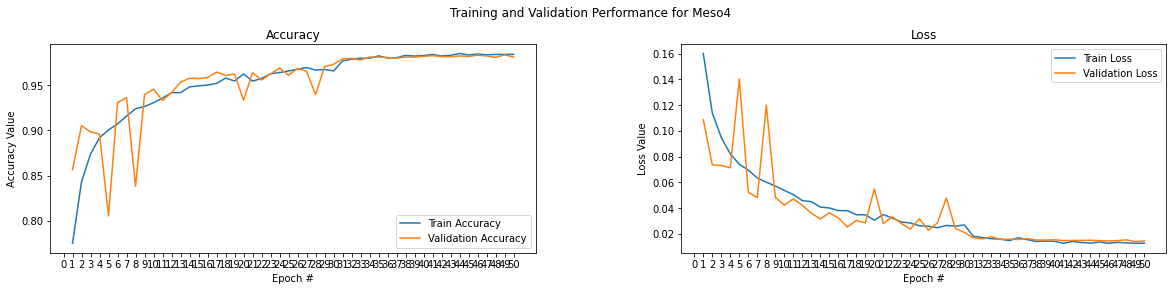

In [15]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance for ' + modelName, fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Prediction

## Folder Paths

In [17]:
import os
directory = os.path.join('deepfake_database', 'validation')
image_format = '.jpg'

## Store into tf.data.Dataset

In [18]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

test_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=False,
    interpolation="bilinear",
)

Found 7104 files belonging to 2 classes.


## Make Prediction

In [19]:
import numpy as np
Y_pred = (model.predict(test_dataset, verbose=1) > 0.5).astype("int32")

111/111 [==============================] - 13s 115ms/step


## Read Original Labels

In [20]:
Y_test = []
for img_array, label in (test_dataset.as_numpy_iterator()):
    Y_test.append(label)

## Flatten Original and Prediction label arrays

In [21]:
import numpy as np

original_labels = []
original_labels = list(np.concatenate(Y_test).flat)
original_labels = np.array(original_labels)

predicted_labels = []
predicted_labels = list(np.concatenate(Y_pred).flat)
predicted_labels = np.array(predicted_labels)

## Classification Report

In [22]:
from sklearn.metrics import classification_report
classificationReport = classification_report(original_labels, predicted_labels, target_names=test_dataset.class_names)
print(classificationReport)

              precision    recall  f1-score   support

          df       0.84      0.93      0.88      2845
        real       0.95      0.88      0.91      4259

    accuracy                           0.90      7104
   macro avg       0.89      0.90      0.90      7104
weighted avg       0.90      0.90      0.90      7104



## Confusion Matrix

True positive =  2633
False positive =  212
False negative =  510
True negative =  3749




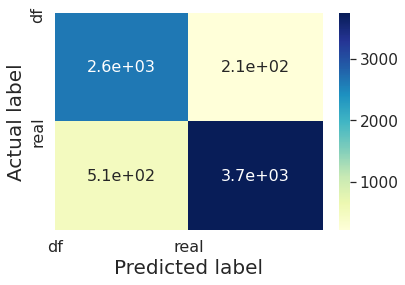

In [23]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.yticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.ylim([2, 0])
    plt.show()
    return cm
    
confusionMatrix = print_confusion_matrix(original_labels, predicted_labels)

# Write to File

In [24]:
import os

tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + str(modelName) + '\n' +
    'Batch Size: ' + str(BATCH_SIZE) + '\n' +
    'Image Size: ' + str(SIZE) + '\n' +
    'Epochs: ' + str(EPOCHS) + '\n' +
    'Iterations: ' + str(ITERATIONS) + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' ' + modelName + '.txt')

myFile = open(filename, 'w')
myFile.write(data)
myFile.close()

model.save(modelName + ' ' + datetime_ist.strftime('%Y-%m-%d %H%M') + '.h5')